# Sentiment Analysis in NLP

Caveat: There is no seed for training the CNN implemented, thus the results differ slightly from run to run.

In [1]:
# Install dependencies
!pip install numpy pandas torch torchinfo scikit-learn gensim nltk tqdm matplotlib

In [25]:
from collections import Counter
from tqdm.auto import tqdm
from pathlib import Path
import contextlib, io
import regex as re

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample

import gensim.downloader as api

import nltk
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

# one‑off downloads
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/kasc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/kasc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
PADDING = 1000 # Padded to that many tokens
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100 # Early stopping is applied
MAX_VOCAB_TOKENS = 40000 # Safety margin
MAX_NORM = 3.0 # Y. Kim's CNN setting for L2-Norm
PAD_IDX = 0 # Embedding matrix gets the zero vector for padding at this index
UNK_IDX = 1 # Same yields for <UNK> tokens at this index

DEVICE # hopefully we're on CUDA

'cuda'

In [ ]:
def loadWord2VecEmbeddings():
    # Function returns the word vectors

    return api.load('word2vec-google-news-300')

def loadDataset() -> pd.DataFrame:
    # Get the raw COCO dataset and return only the ratings and comments

    csv_path = "coco.csv"
    coco = (
        pd.read_csv(
            csv_path,
            usecols=[3, 5],
            header=0,
            names=["learner_rating", "learner_comment"],
            dtype={"learner_rating": "float64", "learner_comment": "string"},
            na_values=["", "NA", "N/A", "null"],
            low_memory=False,
        )
        .dropna(subset=["learner_rating", "learner_comment"])
    )
    return coco[coco["learner_rating"] != 3.9] # Remove noise

def balance_dataset(df, target_size, random_state=42):
    # Balances the highly skewed class distribution to be a uniform distribution of given #classes

    labels = df["learner_rating"].unique()
    per_class = target_size // len(labels)

    samples = []
    for lbl in labels:
        grp = df[df["learner_rating"] == lbl]
        samples.append(

            # Apply undersampling
            resample(
                grp,
                replace=len(grp) < per_class,
                n_samples=per_class,
                random_state=random_state,
            )
        )
    return (
        pd.concat(samples, ignore_index=True)
          .sample(frac=1.0, random_state=random_state)
          .reset_index(drop=True)
    )

def split_dataset(df, text_col="learner_comment", label_col="learner_rating", random_state=42):
    # Split the dataset into 80/10/10 portions

    # final test set: 10 %
    df_train_val, df_test = train_test_split(df,test_size=0.10,stratify=df[label_col],random_state=random_state)

    # validation set: 10 % of full data
    val_relative = 0.10 / 0.90
    df_train, df_val = train_test_split(df_train_val, test_size=val_relative, stratify=df_train_val[label_col],random_state=random_state)

    X_train, y_train = df_train[text_col], df_train[label_col]
    X_val,   y_val   = df_val[text_col],   df_val[label_col]
    X_test,  y_test  = df_test[text_col],  df_test[label_col]

    return X_train, y_train, X_val, y_val, X_test, y_test

def tokenizeFilter(doc):
    # Using TweetTokenizer does almost all we need. We add punctuation removal by using regular expression

    tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    only_punct = re.compile(r'^\p{P}+$')
    
    # Takes a document and applies a NLTK preprocessing pipeline
    return [[tok.lower() for tok in tt.tokenize(text) if not only_punct.match(tok)] for text in tqdm(doc, desc="Preprocessing Corpus")]

def buildVocab(tokenized_docs, numMostFreqTokens):
    # We manually build the vocabulary for having control about its indeces

    tokens = [tok for doc in tokenized_docs for tok in doc]

    # start enumerating at 2 to reserve 0 and 1 for padding and <UNK>
    word2idx = {w: i + 2 for i, (w, _) in enumerate(Counter(tokens)
                                                     .most_common(numMostFreqTokens))}
    print(f"Vocab size (incl. UNK): {len(word2idx)+2}")
    return word2idx

def vocab2sequence(word2idx, doc):
    # Transforms the tokens into their respective index position in vocabulary

    return [word2idx.get(tok, UNK_IDX) for tok in doc]

def sequence_padding(sequence, padding_len):
    # Pad the numeric sequences into a fixed vector length

    padded = np.zeros(padding_len, dtype="int32")
    if not sequence:
        return padded
    seq = sequence[-padding_len:]
    padded[-len(seq):] = seq
    return padded

def buildEmbeddingMatrix(word2idx, word_vectors):
    # Build a loo-up-table what connects the token ideces to word2vec embedding indices

    vocab_size = len(word2idx) + 2 # +2 for PAD + UNK
    embed_dim  = 300

    # Initialize the <UNK> tokens vector randomly
    mat = torch.randn(vocab_size, embed_dim) * 0.05

    # Padding vector stays zero
    mat[PAD_IDX] = torch.zeros(embed_dim)

    # Do the actual mapping
    for word, idx in word2idx.items():
        try:
            mat[idx] = torch.tensor(word_vectors[word])
        except KeyError:
            pass
    print("Embedding matrix:", mat.shape)
    return mat

class KimCNN(nn.Module):
    # Kim (2014) sentence‑classification CNN
    # non‑static variant ( = a single, trainable embedding channel)

    # Hyperparameters were taken from the original paper
    def __init__(
        self,
        embedding_matrix: torch.FloatTensor,
        num_classes: int = 2,
        filter_sizes: tuple = (3, 4, 5),
        num_filters: int = 100,
        dropout: float = 0.5
    ):
        super().__init__()

        # Use torch's embedding layer to do the actual embedding look-up
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=PAD_IDX
        )

        embed_dim = embedding_matrix.size(1)

        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim)) for fs in filter_sizes])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        # Apply the architecture as it was proposed in the original paper

        x = self.embedding(x)
        x = x.unsqueeze(1)
        pooled = []
        for conv in self.convs:
            c = F.relu(conv(x)).squeeze(3)
            p = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2)
            pooled.append(p)
        z = torch.cat(pooled, dim=1)
        z = self.dropout(z)
        logits = self.fc(z)
        return logits

def labels_to_class_ids(series):
    # 0.5 → 0, 1.0 → 1, …, 5.0 → 9

    return ((series.to_numpy() - 0.5) / 0.5).astype(np.int64)

def runFullPipeline(doc):
    # Full pipeline contains building vocabulary + embedding matrix

    # Load the Google News word embeddings
    word_vectors = loadWord2VecEmbeddings()

    # Tokenize and filter documents
    tokenized_docs = tokenizeFilter(doc)

    # Build the vocab only once
    word2idx = buildVocab(tokenized_docs,MAX_VOCAB_TOKENS)

    # Translate the tokenized documents into vocabulary indices
    doc_sequences = [vocab2sequence(word2idx, td) for td in tokenized_docs]

    # Pad the arrays to a fixed length
    doc_sequences_padded = [sequence_padding(ds, PADDING) for ds in doc_sequences]

    # Build embedding matrix only once
    embedding_matrix = buildEmbeddingMatrix(word2idx,word_vectors)

    return word2idx, doc_sequences_padded, embedding_matrix

def runPrePipeline(doc,word2idx):
    # Run only preprocessing on documents without building vocab and embedding matrix

    # Tokenize and filter documents
    tokenized_docs = tokenizeFilter(doc.tolist())

    # Translate the tokenized documents into vocabulary indices
    doc_sequences = [vocab2sequence(word2idx, td) for td in tokenized_docs]

    # Pad the arrays to a fixed length
    doc_sequences_padded = [sequence_padding(ds, PADDING) for ds in doc_sequences]

    return doc_sequences_padded

In [37]:
# Load the COCO dataset
df = loadDataset()

# Split the dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(df)

# Balance the training set to 6 500 samples per rating
train_df = balance_dataset(
    pd.DataFrame({"learner_comment": X_train, "learner_rating": y_train}),
    target_size=6_500 * 10,
)
X_train, y_train = train_df["learner_comment"], train_df["learner_rating"]

# Balancing is also applied to validation and test set to make use of accuracy
# Balance validation
val_df = balance_dataset(pd.DataFrame({"learner_comment": X_val, "learner_rating": y_val}), target_size=6_500*10)
X_val, y_val = val_df["learner_comment"], val_df["learner_rating"]

# Balance test
test_df = balance_dataset(pd.DataFrame({"learner_comment": X_test, "learner_rating": y_test}), target_size=6_500*10)
X_test, y_test = test_df["learner_comment"], test_df["learner_rating"]

# Build vocab / embeddings from training data only
word2idx, _, embedding_matrix = runFullPipeline(X_train.tolist())

Preprocessing Corpus: 100%|██████████| 65000/65000 [00:06<00:00, 10634.99it/s]


Vocab size (incl. UNK): 27584
Embedding matrix: torch.Size([27584, 300])


In [8]:
# The training class labels should now got balanced to 6500 per class
Counter(y_train)

Counter({1.0: 6500,
         3.0: 6500,
         5.0: 6500,
         2.0: 6500,
         2.5: 6500,
         3.5: 6500,
         1.5: 6500,
         0.5: 6500,
         4.5: 6500,
         4.0: 6500})

In [9]:
# Preprocess the comments
# We did before just building the vocabulary and the embedding matrix but now we like to apply only the pre-processing without rebuilding those two parts
X_train = torch.from_numpy(np.array(runPrePipeline(X_train,word2idx)))
X_val = torch.from_numpy(np.array(runPrePipeline(X_val,word2idx)))
X_test = torch.from_numpy(np.array(runPrePipeline(X_test,word2idx)))

Preprocessing Corpus: 100%|██████████| 65000/65000 [00:05<00:00, 11530.86it/s]


In [10]:
# Put the labels also into tensors for training
y_train = torch.tensor(labels_to_class_ids(y_train), dtype=torch.long)
y_val   = torch.tensor(labels_to_class_ids(y_val),   dtype=torch.long)
y_test  = torch.tensor(labels_to_class_ids(y_test),  dtype=torch.long)

In [12]:
# We set the loss function for the classification task. We won't show it as a regression task, as discussed in the presentation, since this was just for comparison purposes.
loss_fn = nn.CrossEntropyLoss()

# Initialize the CNN model
model = KimCNN(embedding_matrix, num_classes=10).to(DEVICE)

# Use Adadelta optimizer as mentioned in the paper of Y. Kim
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

# Take batches from training data
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=200, shuffle=True, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=200, shuffle=False, pin_memory=True)

# A value what is never reached
val_loss_prior = 9999

# Patience for early stopping
patience = 3

# Run the model training
for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total   = 0

    for xb, yb in tqdm(train_loader, desc="Training   ..."):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(xb)
        loss   = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        # Renormalize the weight after each update using L2‑norm
        with torch.no_grad():
            model.fc.weight.renorm_(2, 0, MAX_NORM)
            for conv in model.convs:
                conv.weight.renorm_(2, 0, MAX_NORM)

        # Track statisitcs
        running_loss += loss.item()
        preds = logits.argmax(1)
        running_correct += (preds == yb).sum().item()
        running_total   += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc  = running_correct / running_total

    
    # validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total   = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc="Validating ..."):
            xb = xb.to(DEVICE, non_blocking=True,)
            yb = yb.to(DEVICE, non_blocking=True)

            logits = model(xb)
            val_loss += loss_fn(logits, yb).item()

            preds = logits.argmax(1)
            val_correct += (preds == yb).sum().item()
            val_total   += yb.size(0)

    val_loss /= len(val_loader)
    val_acc   = val_correct / val_total

    print(
        f"epoch {epoch:03d} | "
        f"train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f} | val_acc={val_acc:.3f}",
        flush=True
    )

    if val_loss < val_loss_prior:
        # Loss is better than before
        val_loss_prior = val_loss

        # Reset patience
        patience = 3

        # Remember model for storing after training
        checkpoint = {
            "model_sd": model.state_dict(),
            "word2idx":   word2idx,
            "padding":    PADDING,
            "label_map":  {i: r for i, r in enumerate(np.arange(0.5, 5.1, 0.5))},
            "epoch":      epoch + 1,
            "optim_sd":   optimizer.state_dict(),
            "val_loss":   val_loss,
            "torch_ver":  torch.__version__,
        }
    else:
        # Loss is worse than before
        # Loose patience
        patience -= 1
        if patience < 1:
            print("Early stopping")
            break


# Store the best model
ckpt_path = Path("CNN_COCO_CLASSIFICATION.ckpt")
torch.save(checkpoint, ckpt_path)


Validating ...: 100%|██████████| 325/325 [00:27<00:00, 11.86it/s]

epoch 000 | train_loss=1.9937 | train_acc=0.219 | val_loss=1.8558 | val_acc=0.265



Validating ...: 100%|██████████| 325/325 [00:27<00:00, 11.79it/s]

epoch 001 | train_loss=1.8443 | train_acc=0.270 | val_loss=1.8222 | val_acc=0.269



Validating ...: 100%|██████████| 325/325 [00:27<00:00, 11.72it/s]

epoch 002 | train_loss=1.7969 | train_acc=0.291 | val_loss=1.8215 | val_acc=0.269



Validating ...: 100%|██████████| 325/325 [00:27<00:00, 11.99it/s]

epoch 003 | train_loss=1.7600 | train_acc=0.308 | val_loss=1.8116 | val_acc=0.274



Validating ...: 100%|██████████| 325/325 [00:27<00:00, 12.02it/s]

epoch 004 | train_loss=1.7206 | train_acc=0.326 | val_loss=1.8134 | val_acc=0.276



Validating ...: 100%|██████████| 325/325 [00:29<00:00, 11.12it/s]

epoch 005 | train_loss=1.6831 | train_acc=0.343 | val_loss=1.8132 | val_acc=0.274



Validating ...: 100%|██████████| 325/325 [00:26<00:00, 12.43it/s]

epoch 006 | train_loss=1.6450 | train_acc=0.363 | val_loss=1.8201 | val_acc=0.270


Early stopping


In [18]:
print(f"The model with validation loss of {round(checkpoint['val_loss'],4)} was chosen.")

The model with validation loss of 1.8116 was chosen.


In [19]:
# Remember the best model epoch
model.load_state_dict(checkpoint["model_sd"])

<All keys matched successfully>

In [20]:
# Evaluate the model on the unseen test dataset
model.eval()

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=200, shuffle=False)

all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        logits = model(xb)
        preds  = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(yb.cpu())

all_preds   = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

### Caveat: The seeds are not fixed, so different results may appear than those shown during the presentation.

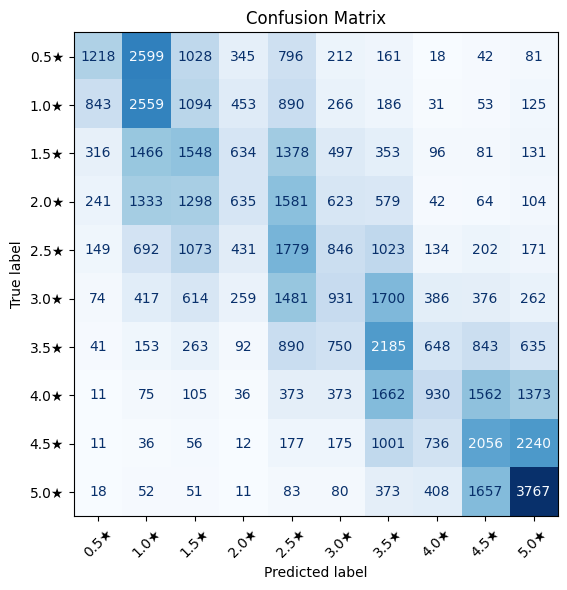

In [21]:
# Plot the confusion matrix for the classifier task
cm = confusion_matrix(all_targets, all_preds)
class_names = [f"{s:.1f}★" for s in np.arange(0.5, 5.5, 0.5)]
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### The overall accuracy (predictive power), as shown in the presentation, stays almost the same.

In [26]:
# Print the F1 per class scores
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.42      0.19      0.26      6500
           1       0.27      0.39      0.32      6500
           2       0.22      0.24      0.23      6500
           3       0.22      0.10      0.13      6500
           4       0.19      0.27      0.22      6500
           5       0.20      0.14      0.17      6500
           6       0.24      0.34      0.28      6500
           7       0.27      0.14      0.19      6500
           8       0.30      0.32      0.31      6500
           9       0.42      0.58      0.49      6500

    accuracy                           0.27     65000
   macro avg       0.27      0.27      0.26     65000
weighted avg       0.27      0.27      0.26     65000



In [27]:
# Run our model on some examples to show its performance

model.eval()

# Build star label
label_stars = {
    i: "★" * int(r) + ("⯨" if r % 1 else "") + "☆" * (5 - int(r) - (1 if r % 1 else 0))
    for i, r in enumerate(np.arange(0.5, 5.1, 0.5))
}

comments = [
    # Own comments which were made-up
    #Rating — 5
    "Absolutely loved every minute of this course! The instructor explained complex concepts with real‑world analogies, the quizzes actually reinforced what I’d learned, and the community Q&A section was active and helpful. I came in as a total beginner and now feel confident enough to build my own small projects. Worth every penny—highly recommended!",
    # Rating — 4
    "The course material is thorough and up‑to‑date, and the downloadable resources are a gold mine. A few lectures felt rushed, so I had to replay them, but overall the pacing was solid. If you already have some background knowledge, this will take you to the next level.",
    # Rating — 3
    "The course was decent: clear slides, decent sound quality, and helpful assignments. That said, several sections were basically the same content I’ve seen for free on YouTube, and a couple of promised topics were only touched on for a few minutes. Good refresher, but not mind‑blowing.",
    # Rating — 2
    "I finished the course, but it felt more like a long slideshow than an interactive learning experience. The instructor read verbatim from the slides and rarely demonstrated the concepts live. Some links were outdated, and the coding examples didn’t always compile without tweaks.",
    # Rating — 0.5
    "Honestly disappointed. The audio was muffled, sections were missing altogether, and the instructor never responded to student questions. I spent half my time searching external forums to figure things out. Save your money and look elsewhere.",

    # Ground‑truth examples out of the COCO dataset
    ("The course is far below my expectation. As a desktop GIS user I can merge "           # 0.5
     "tables in my favorite GIS desktop software without the need to use fusion tables. "
     "Learning how to use fusion tables is not my idea of learning web based GIS and "
     "wouldn't have paid for the course if I knew that beforehand. Disappointed."),
    ("Compared to the foundation course, this course is rushed and repetitive.  "           # 1.0
     "The lessons aren't really lessons, but rather watching the instructor work "
     "while he quickly rattles off his actions."),
    ("While I like this video he seems to repeat quite a bit and avoids camera "            # 2.5
     "settings involved and only describes the lighting of portraits."),
    "Excellent course from which I have gained a lot of information. Thank you",            # 5.0
]

with torch.no_grad():
    for comment in comments:
        # Hide tqdm output
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            xb = torch.tensor(runPrePipeline(np.array([comment]), word2idx)).to(DEVICE)

        logits = model(xb)
        pred   = logits.argmax(1).item()

        print(f"predicted {label_stars[pred]}  (class {pred})\nComment: {comment}\n", flush=True)

predicted ★★★★★  (class 9)
Comment: Absolutely loved every minute of this course! The instructor explained complex concepts with real‑world analogies, the quizzes actually reinforced what I’d learned, and the community Q&A section was active and helpful. I came in as a total beginner and now feel confident enough to build my own small projects. Worth every penny—highly recommended!

predicted ★★★★☆  (class 7)
Comment: The course material is thorough and up‑to‑date, and the downloadable resources are a gold mine. A few lectures felt rushed, so I had to replay them, but overall the pacing was solid. If you already have some background knowledge, this will take you to the next level.

predicted ★★★☆☆  (class 5)
Comment: The course was decent: clear slides, decent sound quality, and helpful assignments. That said, several sections were basically the same content I’ve seen for free on YouTube, and a couple of promised topics were only touched on for a few minutes. Good refresher, but not mi